In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [44]:
NUM_CLASSES = 43
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE

In [50]:
DATA_DIR = "data"
TRAIN_CSV_PATH = os.path.join(DATA_DIR, "Train.csv")
train_csv = pd.read_csv(TRAIN_CSV_PATH)

## Data Loading

In [52]:
image_paths = []
labels = []

for idx, row in train_csv.iterrows():
    rel_path = row["Path"].replace("\\", "/")
    img_path = os.path.join(DATA_DIR, rel_path)
    
    if not os.path.exists(img_path):
        print(f"[Warning] Missing file: {img_path}")
        continue

    try:
        label = int(row["ClassId"])
    except ValueError:
        print(f"[Warning] Invalid label at index {idx}")
        continue

    image_paths.append(img_path)
    labels.append(label)

print(f"Total valid images collected: {len(image_paths)}")

if len(image_paths) == 0:
    raise ValueError("No valid images found. Please check the CSV paths and data directory structure.")

# Convert to tensors
image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
labels = tf.convert_to_tensor(labels, dtype=tf.int32)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    image_paths.numpy(), labels.numpy(), test_size=0.2, stratify=labels.numpy())


Total valid images collected: 39209


## Data Augmentation

In [53]:
# Data augmentation layer
augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

## Preprocessing function

In [54]:
def load_and_preprocess(path, label, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0
    if augment:
        img = augmentation_layer(img)
    return img, tf.one_hot(label, depth=NUM_CLASSES)

# Dataset creation using tf.data
def create_dataset(paths, labels, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: load_and_preprocess(x, y, augment), num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = create_dataset(X_train, y_train, augment=True)
val_ds = create_dataset(X_test, y_test, augment=False)

## Train Custom CNN with Augmented Data

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
123/123 [==============================] - 9s 60ms/step - loss: 1.3428 - accuracy: 0.6451 - val_loss: 0.2877 - val_accuracy: 0.9240
Epoch 2/10
123/123 [==============================] - 7s 52ms/step - loss: 0.1904 - accuracy: 0.9498 - val_loss: 0.1594 - val_accuracy: 0.9588
Epoch 3/10
123/123 [==============================] - 7s 52ms/step - loss: 0.0880 - accuracy: 0.9779 - val_loss: 0.1406 - val_accuracy: 0.9620
Epoch 4/10
123/123 [==============================] - 6s 50ms/step - loss: 0.0565 - accuracy: 0.9848 - val_loss: 0.0969 - val_accuracy: 0.9765
Epoch 5/10
123/123 [==============================] - 7s 53ms/step - loss: 0.0436 - accuracy: 0.9886 - val_loss: 0.0791 - val_accuracy: 0.9832
Epoch 6/10
123/123 [==============================] - 7s 56ms/step - loss: 0.0196 - accuracy: 0.9947 - val_loss: 0.0745 - val_accuracy: 0.9848
Epoch 7/10
123/123 [==============================] - 7s 55ms/step - loss: 0.0159 - accuracy: 0.9961 - val_loss: 0.0777 - val_accuracy: 0.9830

## Evaluate CNN with Accuracy & Confusion Matrix

31/31 [==============================] - 1s 42ms/step

Custom CNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.97      0.98       444
           2       0.97      0.99      0.98       450
           3       0.98      0.97      0.97       282
           4       0.99      1.00      0.99       396
           5       0.96      0.99      0.97       372
           6       1.00      1.00      1.00        84
           7       0.98      0.98      0.98       288
           8       0.99      0.98      0.98       282
           9       1.00      0.99      0.99       294
          10       0.99      1.00      0.99       402
          11       0.98      1.00      0.99       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      1.00      1.00       156
          15       1.00      1.00      1.00   

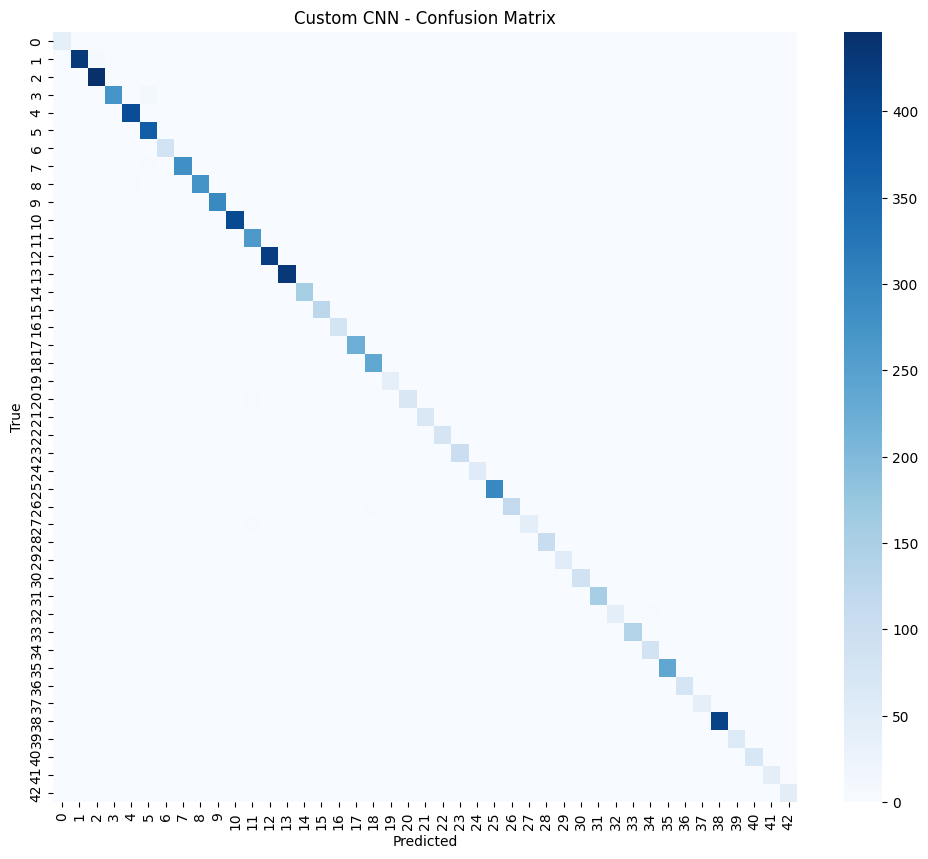

In [57]:
y_pred_probs_cnn = model.predict(val_ds)
y_pred_cnn = np.argmax(y_pred_probs_cnn, axis=1)
y_true = np.argmax(np.concatenate([y for x, y in val_ds], axis=0), axis=1)

print("\nCustom CNN Classification Report:")
print(classification_report(y_true, y_pred_cnn))

cm_cnn = confusion_matrix(y_true, y_pred_cnn)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_cnn, annot=False, fmt='d', cmap='Blues')
plt.title('Custom CNN - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## MobileNetV2 Model

In [58]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

mobilenet_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

mobilenet_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

mobilenet_model.fit(train_ds, validation_data=val_ds, epochs=10)


9406464/9406464 [==============================] - 3s 0us/step
Epoch 1/10
123/123 [==============================] - 10s 58ms/step - loss: 2.1195 - accuracy: 0.4056 - val_loss: 1.2961 - val_accuracy: 0.6024
Epoch 2/10
123/123 [==============================] - 6s 51ms/step - loss: 1.2546 - accuracy: 0.6098 - val_loss: 0.9718 - val_accuracy: 0.6971
Epoch 3/10
123/123 [==============================] - 7s 52ms/step - loss: 0.9743 - accuracy: 0.6895 - val_loss: 0.8297 - val_accuracy: 0.7427
Epoch 4/10
123/123 [==============================] - 7s 54ms/step - loss: 0.8119 - accuracy: 0.7416 - val_loss: 0.7294 - val_accuracy: 0.7721
Epoch 5/10
123/123 [==============================] - 7s 59ms/step - loss: 0.7043 - accuracy: 0.7757 - val_loss: 0.6618 - val_accuracy: 0.7955
Epoch 6/10
123/123 [==============================] - 7s 59ms/step - loss: 0.6181 - accuracy: 0.8048 - val_loss: 0.6155 - val_accuracy: 0.8085
Epoch 7/10
123/123 [==============================] - 7s 57ms/step - loss: 0.5

## Evaluate MobileNetV2

31/31 [==============================] - 2s 38ms/step

MobileNetV2 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.48      0.65        42
           1       0.87      0.80      0.84       444
           2       0.77      0.82      0.79       450
           3       0.67      0.73      0.69       282
           4       0.77      0.73      0.75       396
           5       0.74      0.80      0.77       372
           6       0.97      0.93      0.95        84
           7       0.86      0.81      0.83       288
           8       0.77      0.72      0.75       282
           9       0.89      0.93      0.91       294
          10       0.85      0.93      0.89       402
          11       0.69      0.82      0.75       264
          12       0.98      0.97      0.97       420
          13       0.98      0.97      0.98       432
          14       0.99      0.98      0.99       156
          15       1.00      0.99      1.00  

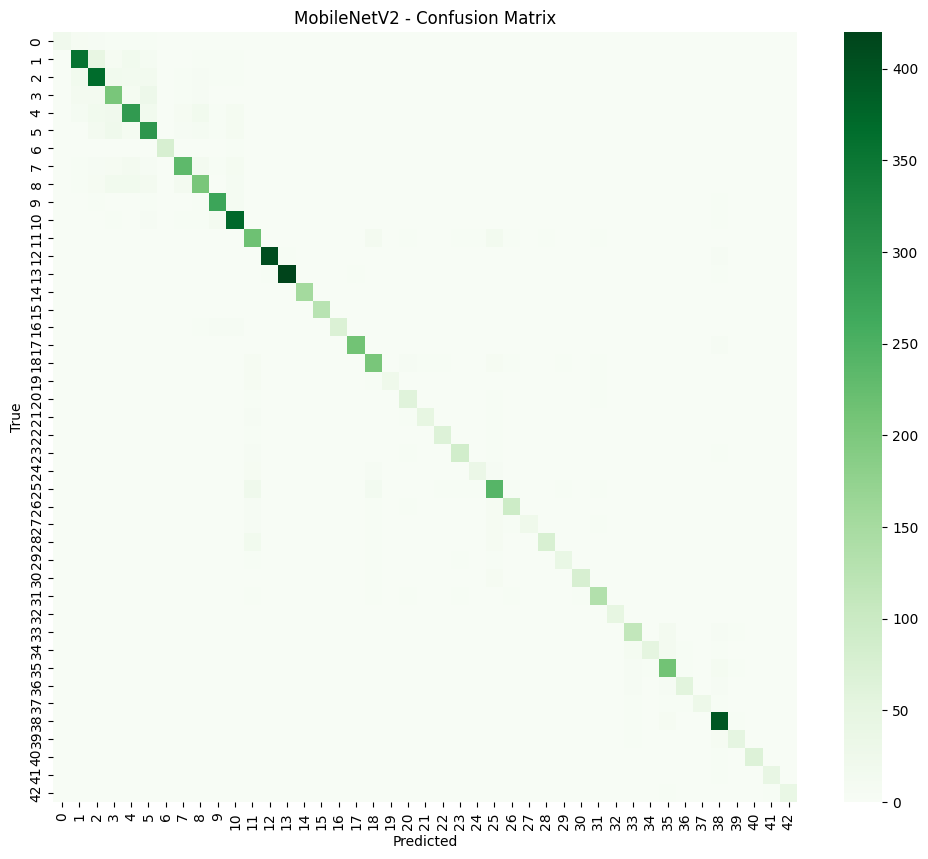

In [59]:
y_pred_probs_mobilenet = mobilenet_model.predict(val_ds)
y_pred_mobilenet = np.argmax(y_pred_probs_mobilenet, axis=1)

print("\nMobileNetV2 Classification Report:")
print(classification_report(y_true, y_pred_mobilenet))

cm_mobilenet = confusion_matrix(y_true, y_pred_mobilenet)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_mobilenet, annot=False, fmt='d', cmap='Greens')
plt.title('MobileNetV2 - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Compare CNN With MobileNetV2


Comparison of Models:
Custom CNN Accuracy: 0.9881
MobileNetV2 Accuracy: 0.8451


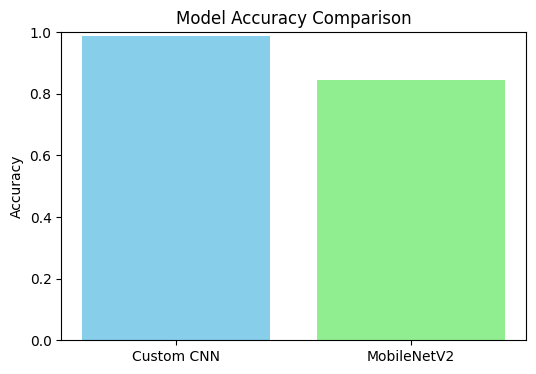

In [60]:
from sklearn.metrics import accuracy_score

acc_cnn = accuracy_score(y_true, y_pred_cnn)
acc_mobilenet = accuracy_score(y_true, y_pred_mobilenet)

print(f"\nComparison of Models:\nCustom CNN Accuracy: {acc_cnn:.4f}\nMobileNetV2 Accuracy: {acc_mobilenet:.4f}")

plt.figure(figsize=(6, 4))
plt.bar(['Custom CNN', 'MobileNetV2'], [acc_cnn, acc_mobilenet], color=['skyblue', 'lightgreen'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()
